# Open PTU files
This notebook opens ".ptu" files and fits FLIM decay data using curve_fit from scipy.

## Set data path

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import napari
from scipy.optimize import curve_fit

In [2]:
#data_path = "C:/Users/mazo260d/Desktop/Conni_BiA_PoL/copied_for_Marcelo/single_image/raw_FLIM_data/single_FLIM_image.ptu"
data_path = "C:/Users/cblei/Desktop/miniSabb_local/FLIM_file_formats/single_FLIM_image.ptu"

In [3]:
data_path = Path(data_path)
print(data_path)

C:\Users\cblei\Desktop\miniSabb_local\FLIM_file_formats\single_FLIM_image.ptu


## Open ptu file

https://github.com/SumeetRohilla/readPTU_FLIM

In [4]:
from readPTU_FLIM import PTUreader

In [5]:
ptu_file = PTUreader(data_path, print_header_data = False)

TCSPC Hardware: PicoHarpT3
Raw Data has been Read!



In [6]:
ptu_file._print_ptu_head()

Head ID                        Value   
File_GUID                      40      
File_CreatingTime              13301658052.442
$StartedByRemoteInterface      1       
Measurement_SubMode            3       
File_Comment                           
TTResult_StopReason            1       
Fast_Load_End                  0       
CreatorSW_Name                 SymPhoTime 64
CreatorSW_Version              1.6     
CreatorSW_SVNBuild             3224    
CreatorSW_Modules              0       
$ReqHdr_RecordVersion          16777728
$ReqHdr_MeasurementType        1       
$ReqHdr_PixelNumber_X          512     
$ReqHdr_PixelNumber_Y          512     
$ReqHdr_ScanningPattern        0       
$ReqHdr_SpatialResolution      0.07035765166
$Filename                      single_FLIM_image
$Comment                               
$Groupname                     single_FLIM_image
ImgHdr_Dimensions              3       
ImgHdr_Ident                   3       
ImgHdr_PixX                    512     
ImgHd

## get FLIM data

In [7]:
flim_data_stack, intensity_image = ptu_file.get_flim_data_stack()

In [8]:
flim_data_stack.shape

(512, 512, 2, 270)

In [9]:
intensity_image.shape

(512, 512)

## plot intensity image with color bar

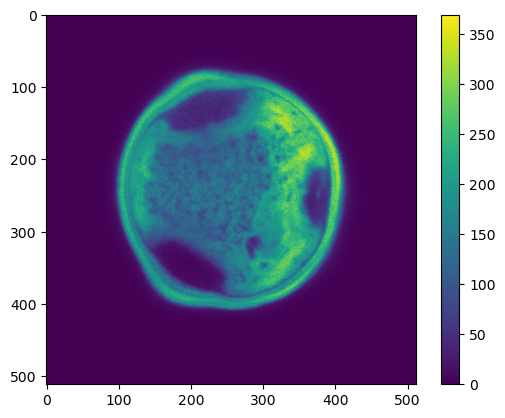

In [10]:
plt.imshow(intensity_image)
plt.colorbar()

Re-arange axes to have (x,y) by the end

In [11]:
flim_data_stack_for_napari = np.moveaxis(flim_data_stack, [0, 1], [-2, -1])

Get only first channel (the second channel for this image is empty)

In [12]:
flim_data_stack_for_napari = flim_data_stack_for_napari[0, :, :, :]

In [13]:
flim_data_stack_for_napari.shape

(270, 512, 512)

## Plot decay histogram from a single pixel

In [14]:
total_time_points = flim_data_stack_for_napari.shape[0]
print('number of time bins per time window: ', total_time_points)

number of time bins per time window:  270


### calculate time window (in ns) between laser pulses from a given laser pulse frequency (in MHz)

In [15]:
laser_frequency = 40 # MHz
laser_time_window = 1 / (laser_frequency * 10**6)
laser_time_window_ns = laser_time_window * 10**9
laser_time_window_ns

25.0

In [16]:
pixel = flim_data_stack_for_napari[:,150,300]

In [17]:
time_step = laser_time_window_ns / total_time_points # ns
print('duration of all time bins: ', round(time_step*1000, 1), ' ps, is fix parameter in LAS X')

duration of all time bins:  92.6  ps, is fix parameter in LAS X


### define the time window between each laser pulse as time_array

In [18]:
time_array = np.arange(0, total_time_points) * time_step

Text(0, 0.5, 'Intensity [counts]')

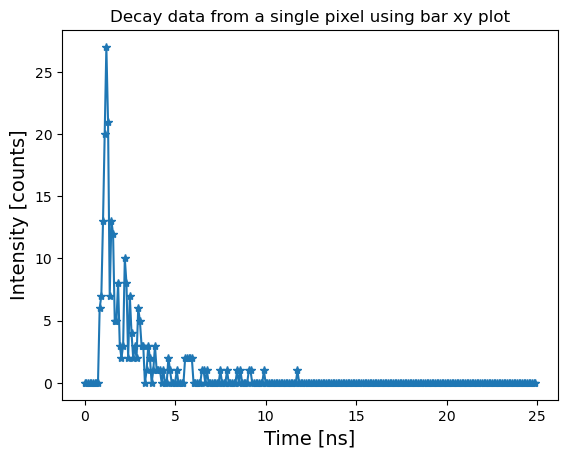

In [19]:
plt.plot(time_array, pixel, '-*')
plt.title('Decay data from a single pixel using bar xy plot')
plt.xlabel('Time [ns]', fontsize=14)
plt.ylabel('Intensity [counts]', fontsize=14)

Text(0, 0.5, 'Intensity [counts]')

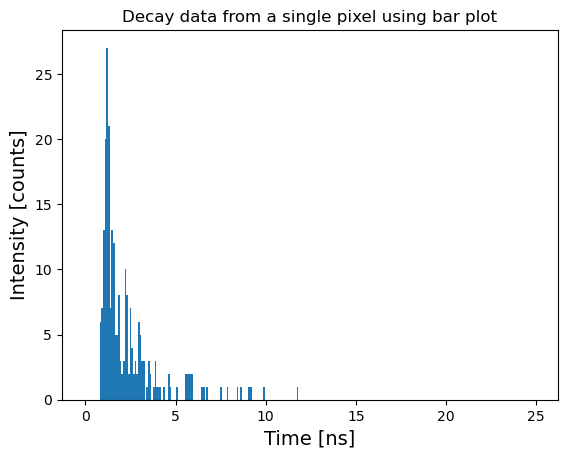

In [20]:
plt.bar(time_array, pixel, width = time_step)
plt.title('Decay data from a single pixel using bar plot')
plt.xlabel('Time [ns]', fontsize=14)
plt.ylabel('Intensity [counts]', fontsize=14)

In [21]:
mask = pixel != 0
time_array_non_zero = time_array[mask]
pixel_non_zero= pixel[mask]

<BarContainer object of 55 artists>

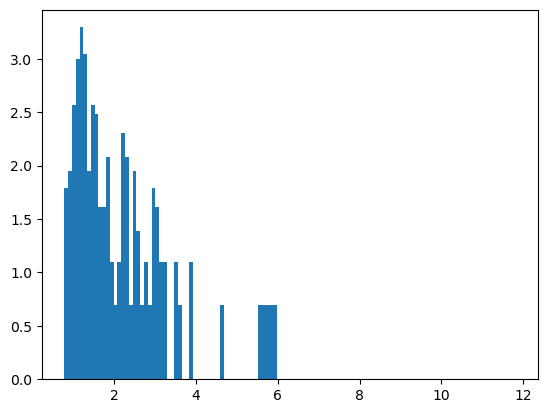

In [22]:
plt.bar(time_array_non_zero, np.log(pixel_non_zero), width = time_step)

## Plot ROI over time

In [23]:
roi1 = flim_data_stack_for_napari[:,120:150, 320:350]
roi2 = flim_data_stack_for_napari[:,220:250, 220:250]                       

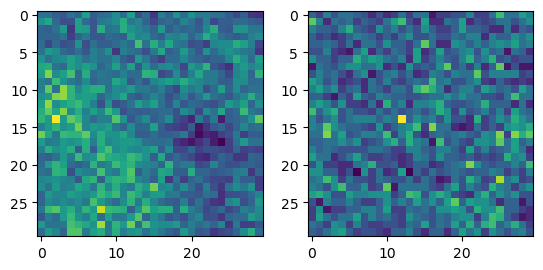

In [24]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.max(roi1, axis=0))
ax[1].imshow(np.max(roi2, axis=0))

In [25]:
sum_intensity_roi1 = np.sum(roi1, axis = (1,2))
sum_intensity_roi2 = np.sum(roi2, axis = (1,2))

mask1 = sum_intensity_roi1 != 0
mask2 = sum_intensity_roi2 != 0

sum_intensity_roi1_non_zero = sum_intensity_roi1[mask1]
sum_intensity_roi2_non_zero = sum_intensity_roi2[mask2]

time_array_roi1 = time_array[mask1]
time_array_roi2 = time_array[mask2]

<BarContainer object of 270 artists>

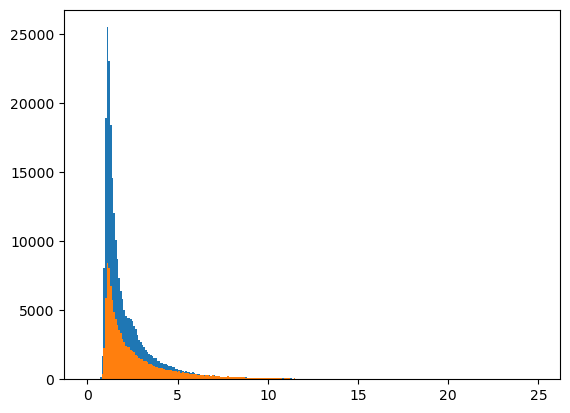

In [26]:
plt.bar(time_array, sum_intensity_roi1, width = time_step)
plt.bar(time_array, sum_intensity_roi2, width = time_step)

<BarContainer object of 264 artists>

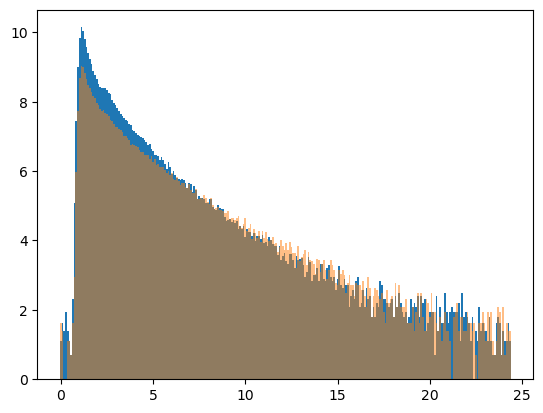

In [27]:
plt.bar(time_array_roi1, np.log(sum_intensity_roi1_non_zero), width = time_step)
plt.bar(time_array_roi2, np.log(sum_intensity_roi2_non_zero), width = time_step, alpha = 0.5)

# Perfom curve fit

In [28]:
starting_index = np.argmax(np.log(sum_intensity_roi1_non_zero))
decay_mask = time_array_roi1 >= time_array_roi1[starting_index]

In [29]:
x_data_to_fit = time_array_roi1[decay_mask]
y_data_to_fit = np.log(sum_intensity_roi1_non_zero)[decay_mask]

### Perform line fit

In [30]:
def line(x, c, d):
    import numpy as np
    return - (c * x) + d

In [31]:
parameters_optimal_line, parameters_covariance_line = curve_fit(line, x_data_to_fit, y_data_to_fit)
residues_line = np.log(sum_intensity_roi1_non_zero) - line(time_array_roi1, *parameters_optimal_line)
total_residue_line = np.sum(abs(residues_line**2))/len(time_array_roi1)

In [32]:
parameters_optimal_line

array([0.32565958, 8.17446022])

<BarContainer object of 264 artists>

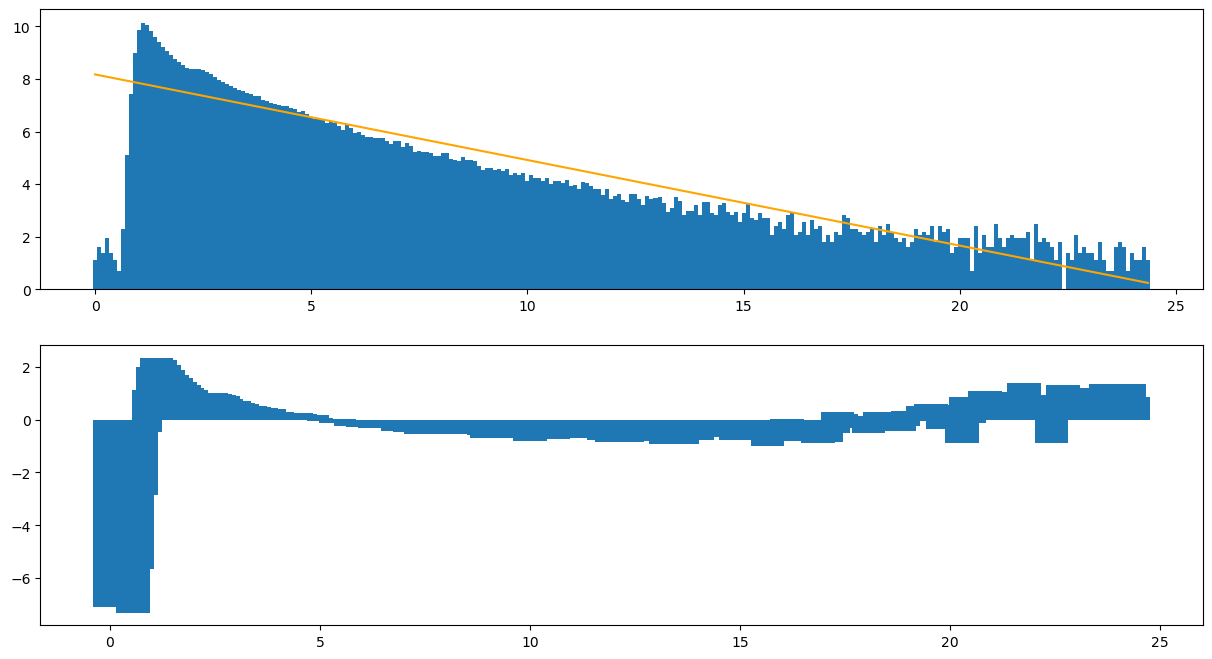

In [33]:
fig, ax = plt.subplots(2,1, figsize = (15,8))
ax[0].bar(time_array_roi1, np.log(sum_intensity_roi1_non_zero), width = time_step)
ax[0].plot(time_array_roi1, line(time_array_roi1, *parameters_optimal_line), 'orange')
ax[1].bar(time_array_roi1, residues_line)

### Perform 3 component line fit

In [34]:
def line2(x, c1, d1, c2, d2, c3, d3):
    import numpy as np
    return - (c1 * x) - (c2 * x) - (c3 * x) + d1 + d2 + d3

In [35]:
lower_bounds = 0
upper_bounds = [5, 200, 2, 200, 1, 200]

In [36]:
intial_parameters = [0.2, 16, 0.05, 4, 0.01, 1]

In [37]:
parameters_optimal_line2, parameters_covariance_line2 = curve_fit(line2, x_data_to_fit, y_data_to_fit,
                                                                 bounds = (lower_bounds, upper_bounds),
                                                                 p0 = intial_parameters)
residues_line2 = np.log(sum_intensity_roi1_non_zero) - line2(time_array_roi1, *parameters_optimal_line2)
total_residue_line2 = np.sum(abs(residues_line2**2))/len(time_array_roi1)

In [38]:
parameters_optimal_line2

array([0.22426027, 6.0884355 , 0.07314671, 1.65422032, 0.0282526 ,
       0.43180441])

<BarContainer object of 264 artists>

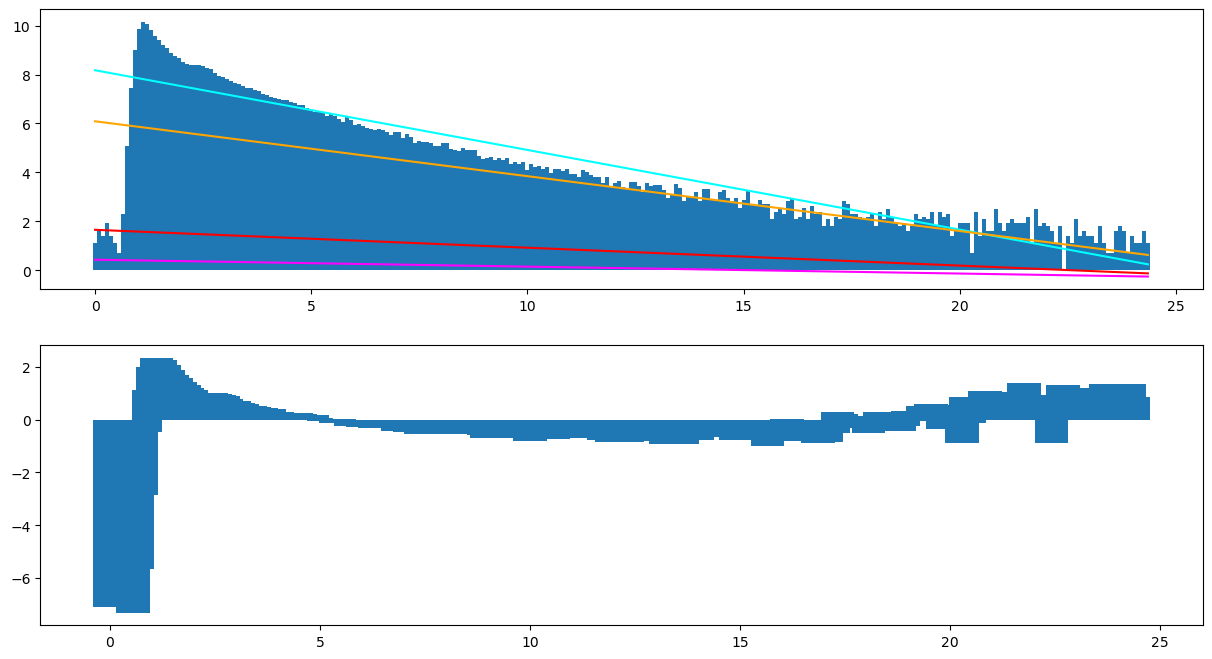

In [39]:
fig, ax = plt.subplots(2,1, figsize = (15,8))
ax[0].bar(time_array_roi1, np.log(sum_intensity_roi1_non_zero), width = time_step)
ax[0].plot(time_array_roi1, line2(time_array_roi1, *parameters_optimal_line2), 'cyan')
ax[0].plot(time_array_roi1, line(time_array_roi1, *parameters_optimal_line2[:2]), 'orange')
ax[0].plot(time_array_roi1, line(time_array_roi1, *parameters_optimal_line2[2:4]), 'red')
ax[0].plot(time_array_roi1, line(time_array_roi1, *parameters_optimal_line2[4:]), 'magenta')

ax[1].bar(time_array_roi1, residues_line2)

## Perform Exponential fit
this works for exponential FLIM decays

### single component fit

In [40]:
def exp1(x, a, b):
    import numpy as np
    return (a * np.exp(-b * x))         # definition of exponential function to be used for fitting

In [41]:
x_data_to_fit = time_array_roi1[decay_mask]
y_data_to_fit = sum_intensity_roi1_non_zero[decay_mask]

In [42]:
parameters_optimal_exp1, parameters_covariance_exp1 = curve_fit(exp1, x_data_to_fit, y_data_to_fit)
# residues_exp1 = sum_intensity_roi1_non_zero - exp1(time_array_roi1, *parameters_optimal_exp1)
# total_residue_exp1 = np.sum(abs(residues_exp1**2))/len(time_array_roi1)

C:\Users\cblei\AppData\Local\Temp\ipykernel_13584\4125444165.py:3: RuntimeWarning: overflow encountered in exp
  return (a * np.exp(-b * x))         # definition of exponential function to be used for fitting
C:\Users\cblei\AppData\Local\Temp\ipykernel_13584\4125444165.py:3: RuntimeWarning: overflow encountered in multiply
  return (a * np.exp(-b * x))         # definition of exponential function to be used for fitting


In [43]:
parameters_optimal_exp1

array([1.29403197e+05, 1.51673359e+00])

Text(0, 0.5, 'Intensity [counts]')

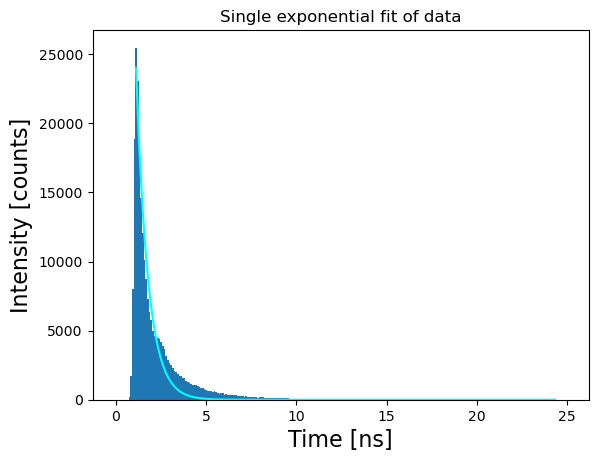

In [44]:
plt.bar(time_array, sum_intensity_roi1, width = time_step)
plt.plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp1)[decay_mask], 'cyan')
plt.title('Single exponential fit of data')
plt.xlabel('Time [ns]', fontsize=16)
plt.ylabel('Intensity [counts]', fontsize=16)

### two component fit

In [45]:
def exp2(x, a1, b1, a2, b2):
    import numpy as np
    return (a1 * np.exp(-b1 * x)) + (a2 * np.exp(-b2 * x))       # double exponential decay

In [46]:
parameters_optimal_exp2, parameters_covariance_exp2 = curve_fit(exp2, x_data_to_fit, y_data_to_fit)

C:\Users\cblei\AppData\Local\Temp\ipykernel_13584\1546417996.py:3: RuntimeWarning: overflow encountered in exp
  return (a1 * np.exp(-b1 * x)) + (a2 * np.exp(-b2 * x))       # double exponential decay
C:\Users\cblei\AppData\Local\Temp\ipykernel_13584\1546417996.py:3: RuntimeWarning: overflow encountered in multiply
  return (a1 * np.exp(-b1 * x)) + (a2 * np.exp(-b2 * x))       # double exponential decay


In [47]:
parameters_optimal_exp2

array([5.31169483e+05, 2.97317305e+00, 1.33718586e+04, 5.66642299e-01])

Text(0, 0.5, 'Intensity [counts]')

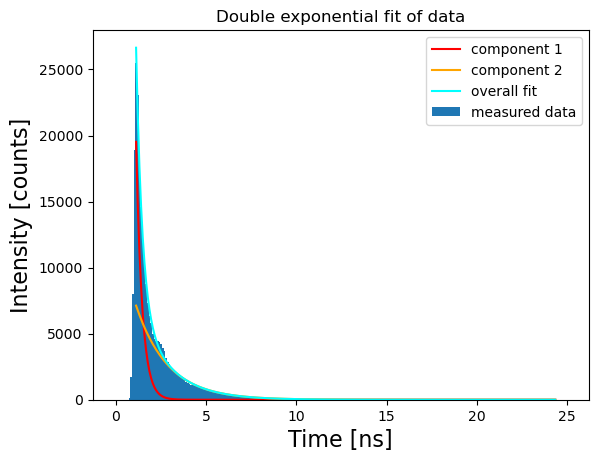

In [48]:
plt.bar(time_array, sum_intensity_roi1, width = time_step)
plt.plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp2[0:2])[decay_mask], 'red')
plt.plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp2[2:4])[decay_mask], 'orange')
plt.plot(time_array_roi1[decay_mask], exp2(time_array_roi1, *parameters_optimal_exp2)[decay_mask], 'cyan')
plt.legend(['component 1', 'component 2','overall fit','measured data'])
plt.title('Double exponential fit of data')
plt.xlabel('Time [ns]', fontsize=16)
plt.ylabel('Intensity [counts]', fontsize=16)

### three component fit

In [49]:
def exp3(x, a1, b1, a2, b2, a3, b3):
    import numpy as np
    return (a1 * np.exp(-b1 * x)) + (a2 * np.exp(-b2 * x)) + (a3 * np.exp(-b3 * x))       # triple exponential decay function

In [50]:
lower_bounds_exp3 = 0
upper_bounds_exp3 = [1E+20, 20, 1E+20, 20, 1E+20, 20]       # definition of upper bounds of parameters (to be better calculated from data)

In [51]:
intial_parameters_exp3 = [max(sum_intensity_roi1)/3,1,max(sum_intensity_roi1)/3,1,max(sum_intensity_roi1)/3,1]

In [52]:
# parameters_optimal_exp3, parameters_covariance_exp3 = curve_fit(exp3, x_data_to_fit, y_data_to_fit, bounds=(0, inf))

parameters_optimal_exp3, parameters_covariance_exp3 = curve_fit(exp3, x_data_to_fit, y_data_to_fit, bounds = (lower_bounds_exp3, upper_bounds_exp3),
                                                                 p0 = intial_parameters_exp3)

In [53]:
print('all 6 parameters: ', parameters_optimal_exp3)            # all 3 amplitudes and lifetimes
print('the 3 lifetimes [ns]: ', parameters_optimal_exp3[1::2])  # 3 lifetimes only

all 6 parameters:  [1.27243929e+03 1.79545859e+01 1.33719636e+04 5.66644334e-01
 5.31174731e+05 2.97318331e+00]
the 3 lifetimes [ns]:  [17.95458591  0.56664433  2.97318331]


In [54]:
parameters_optimal_exp3[::2]

array([  1272.43928818,  13371.96361096, 531174.7311735 ])

Text(0, 0.5, 'Intensity [counts]')

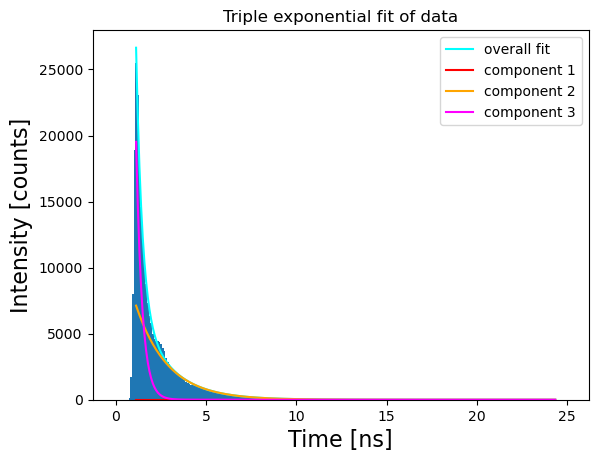

In [55]:
plt.bar(time_array, sum_intensity_roi1, width = time_step)
plt.plot(time_array_roi1[decay_mask], exp3(time_array_roi1, *parameters_optimal_exp3)[decay_mask], 'cyan')
plt.plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp3[0:2])[decay_mask], 'red')
plt.plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp3[2:4])[decay_mask], 'orange')
plt.plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp3[4:6])[decay_mask], 'magenta')
plt.legend(['overall fit', 'component 1','component 2','component 3'])
plt.title('Triple exponential fit of data')
plt.xlabel('Time [ns]', fontsize=16)
plt.ylabel('Intensity [counts]', fontsize=16)

<BarContainer object of 264 artists>

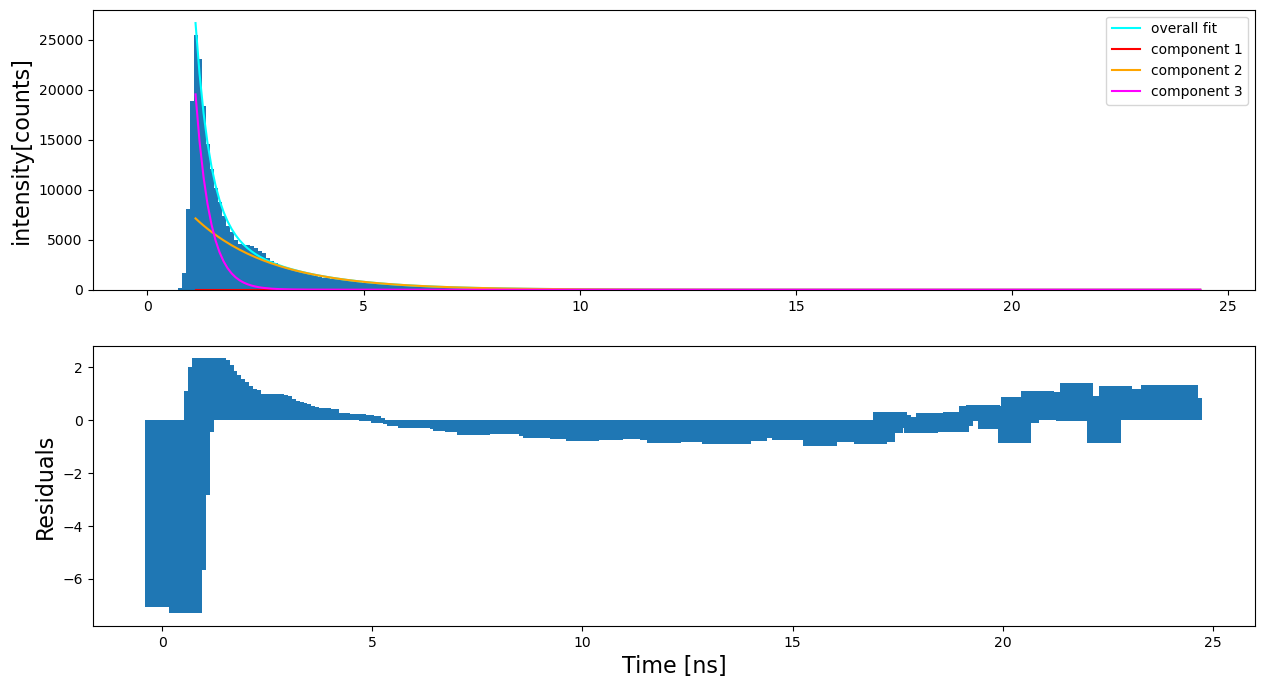

In [56]:
fig, ax = plt.subplots(2,1, figsize = (15,8))
ax[0].bar(time_array_roi1, sum_intensity_roi1_non_zero, width = time_step)

ax[0].plot(time_array_roi1[decay_mask], exp3(time_array_roi1, *parameters_optimal_exp3)[decay_mask], 'cyan')
ax[0].plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp3[0:2])[decay_mask], 'red')
ax[0].plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp3[2:4])[decay_mask], 'orange')
ax[0].plot(time_array_roi1[decay_mask], exp1(time_array_roi1, *parameters_optimal_exp3[4:6])[decay_mask], 'magenta')
ax[0].ylabel = 'Intensity [counts]'
ax[0].legend(['overall fit', 'component 1', 'component 2', 'component 3'])
ax[0].set_ylabel('intensity[counts]', fontsize=16)
ax[1].set_xlabel('Time [ns]', fontsize=16)
ax[1].set_ylabel('Residuals', fontsize=16)

# bar plot of residuals 
ax[1].bar(time_array_roi1, residues_line2)

In [57]:
# popt2, pcov2 = curve_fit(monoexp_and_line, time[idx_msk], photobleaching, bounds=(0, upper_bounds))

In [58]:
# popt3, pcov3 = curve_fit(lambda x, a, b, c, d, e: monoexp_line_step(x,a,b,c,d,e,t_sig_onset), time, ROIs_means[:,j], bounds=(0, upper_bounds